In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimSiamTransform
import torch
from Siamese_Architecture import Siamese1DNet_backbone, SimSiam

import matplotlib.pyplot as plt

BATCH_SIZE = 32

In [31]:
import tqdm
import umap.umap_ as umap
import numpy as np
import hdbscan
import sklearn.metrics as metrics
from SproutDataset import map_item_map

Self-supervised search: run infidence on the backbone+projection head

Feed the spectra thu the backbone, then backbone to proj head. Give 128 values. Encoding spectra to vector of size 128.
End up with vector for each one of the spectra. 

Take those 128 values for all spectra, and pass them to Umap. Turn 128 values to (x,y) coordinates.

In [3]:
dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.nc"
dataset_path_mini = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc"
datasetsingle = SproutDataset(dataset_path=dataset_path_mini, augmentation_type='single')
dataloader = DataLoader(
            datasetsingle,
            batch_size=BATCH_SIZE,
            shuffle=True)

In [4]:
for batch in dataloader:
    if isinstance(batch, list):  # If batch is a list
        batch = torch.stack(batch)  # Stack it into a tensor
    print(batch.shape)  # Should now show [32, 451]
    break

torch.Size([2, 32, 1, 451])


In [5]:
model = SimSiam()
dataset = datasetsingle

wandb_logger = WandbLogger(project="SimSiam_Training_128_contrastive", log_model=True)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [6]:
trainer = pl.Trainer(max_epochs=5, devices=1, accelerator=accelerator, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tava8993 (tava8993-boulder). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | backbone        | Siamese1DNet_backbone | 924 K  | train
1 | projection_head | SimSiamProjectionHead | 16.6 K | train
2 | prediction_head | SimSiamPredictionHead | 8.4 K  | train
3 | criterion       | NTXentLoss            | 0      | train
------------------------------------------------------------------
949 K     Trainable params
0         Non-trainable params
949 K     Total params
3.797     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 3660/3660 [02:31<00:00, 24.12it/s, v_num=p00v]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3660/3660 [02:31<00:00, 24.11it/s, v_num=p00v]


In [8]:
checkpoint = "C:\\Users\\tania\\Documents\\CU Boulder\\CU Fall 2024\\ASEN 6337\\Individual project\\SPICE_DeepLearning\\SimSiam_Training_128_contrastive\\50a3p00v\\checkpoints\epoch=4-step=18300.ckpt"
loaded_model = SimSiam.load_from_checkpoint(checkpoint)
loaded_model.eval()

SimSiam(
  (backbone): Siamese1DNet_backbone(
    (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=7168, out_features=128, bias=True)
  )
  (projection_head): SimSiamProjectionHead(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=False)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=

In [9]:
dataset_none = SproutDataset(dataset_path=dataset_path, augmentation_type=None)
dataset_none_mini = SproutDataset(dataset_path=dataset_path_mini, augmentation_type=None)

In [11]:
outputs = []
with torch.no_grad():  # Disable gradient computation for inference
    for i in tqdm.tqdm(range (dataset_none_mini.__len__())):
        spec = dataset_none_mini.__getitem__(i).unsqueeze(0) 

        # Move tensor to the same device as the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loaded_model = loaded_model.to(device)
        spec = spec.to(device)

        outputs.append(loaded_model(spec)[0].cpu().numpy())

100%|██████████| 117120/117120 [05:11<00:00, 375.39it/s]


In [13]:
stacked_outputs = np.stack(outputs).squeeze()

In [27]:
stacked_outputs.shape

(117120, 64)

In [14]:
stacked_outputs_L2 = stacked_outputs / np.linalg.norm(stacked_outputs, ord=2)
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=15, metric='euclidean')
clusterer.fit(stacked_outputs_L2)

labels = clusterer.labels_

In [38]:
from sunraster.instr.spice import read_spice_l2_fits   
import xarray as xr

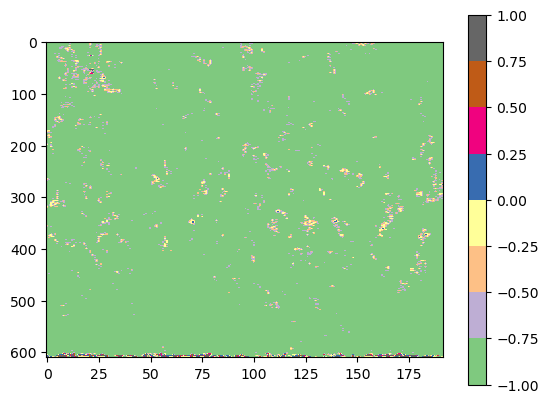

(40, 610, 192)


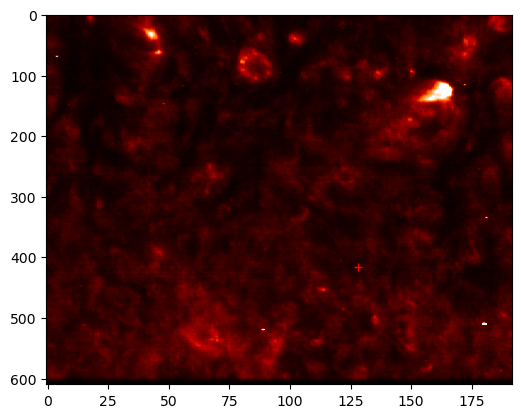

In [ ]:
def map_item_map(item_nbr, dataset, plot=False, data_dir='C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\data_L2\\', key='Ne VIII 770 (Merged)',croplatbottom=725, croplattop=115):
    filename = str(dataset.isel(index=item_nbr)['filename'].data)
    i,j = (dataset.isel(index=item_nbr)['x-index'].data, dataset.isel(index=item_nbr)['y-index'].data)
    exposure = read_spice_l2_fits(data_dir+filename, memmap=False)
    cube = exposure[key][0,:,croplattop:croplatbottom,:].data
    if plot:
        plt.imshow(cube[20, :, :], aspect=1/4, cmap='gist_heat', vmax=np.nanquantile(cube[20, :, :], 0.999))
        print(cube.shape)
        plt.plot(j,i, color='red', marker='+')

datasetmini = xr.open_dataset("C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc")
labels_1file = labels.reshape(610,192)
plt.figure(figsize=(15,6))
plt.subplot(211)
plt.imshow(labels_1file, cmap='Accent', aspect=1/4)
plt.colorbar()
plt.show()
map_item_map(80000, datasetmini, plot=True)

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
projected_data = reducer.fit_transform(stacked_outputs)

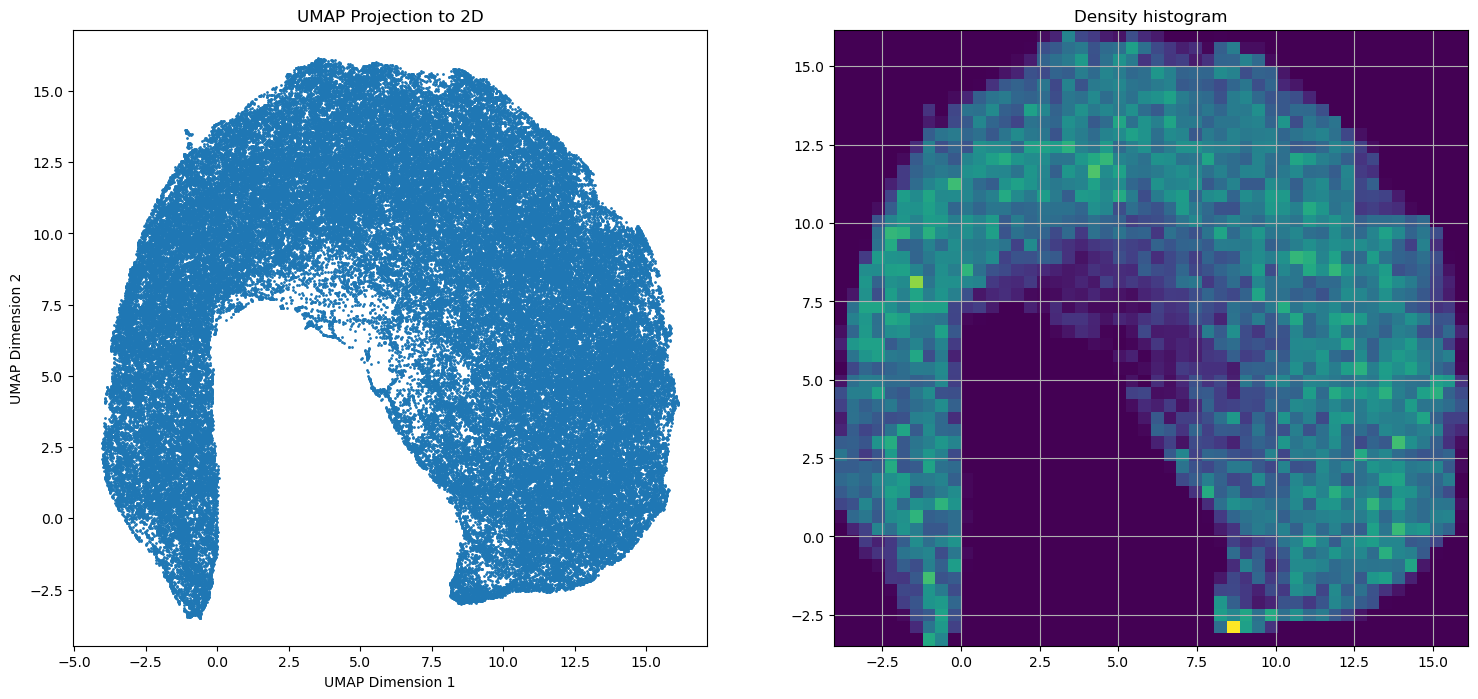

In [17]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], cmap='Spectral', s=1)
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.subplot(122)
plt.hist2d(projected_data[:, 0], projected_data[:, 1], bins=50)
plt.grid(True)
plt.title('Density histogram')
plt.show()

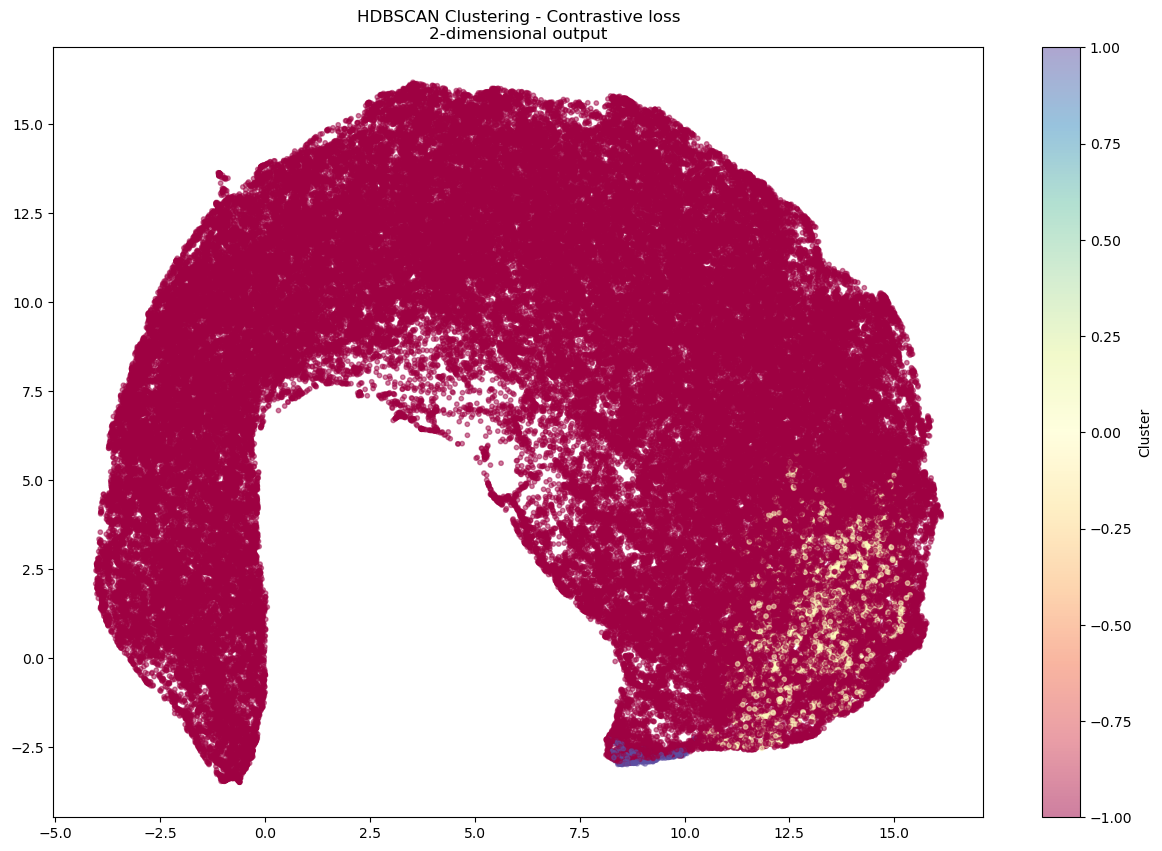

In [25]:
cmap = plt.cm.Spectral
cmap.set_under('white')

plt.figure(figsize=(15,10))
plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='Spectral', s=10, alpha=0.5)
cbar = plt.colorbar(label='Cluster')

plt.title('HDBSCAN Clustering - Contrastive loss\n2-dimensional output')
plt.show()

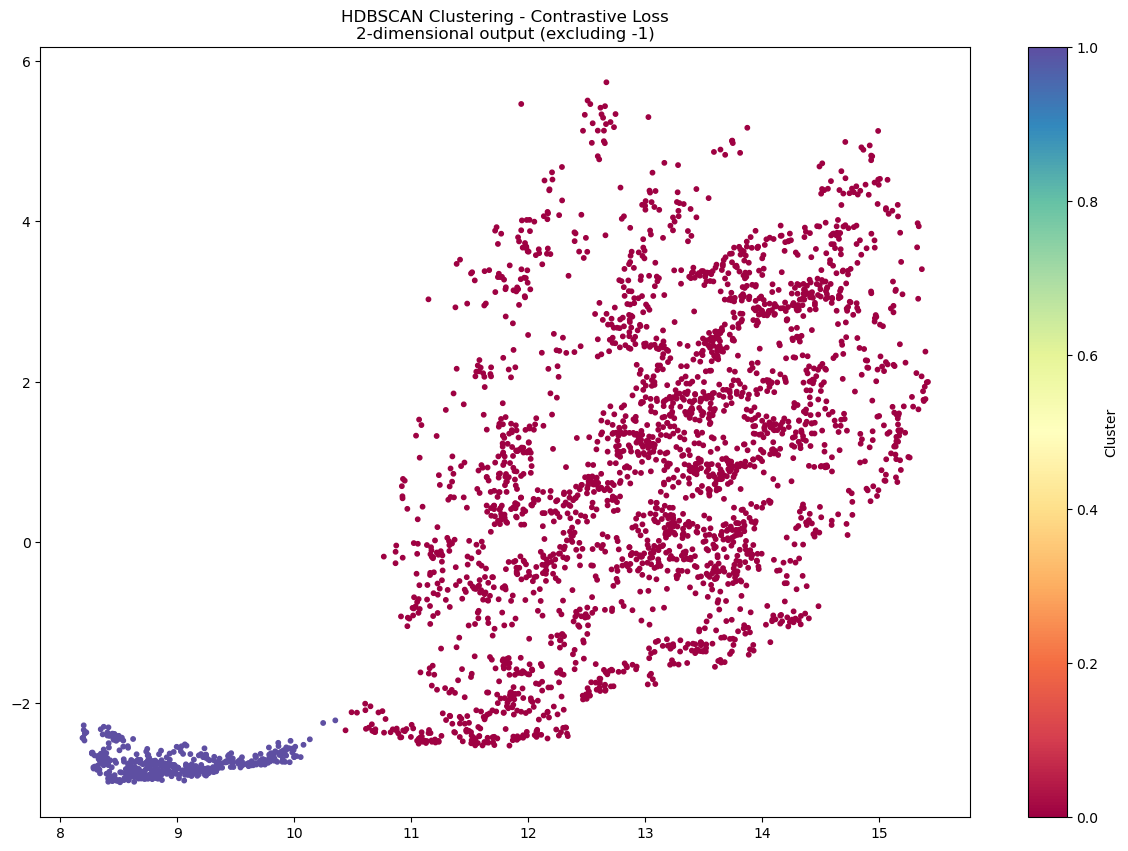

In [23]:
mask = labels != -1
filtered_data = projected_data[mask]
filtered_labels = labels[mask]

# Plot
plt.figure(figsize=(15, 10))
scatter = plt.scatter(
    filtered_data[:, 0],
    filtered_data[:, 1],
    c=filtered_labels,
    cmap='Spectral',
    s=10
)
plt.colorbar(scatter, label='Cluster')
plt.title('HDBSCAN Clustering - Contrastive Loss\n2-dimensional output (excluding -1)')
plt.show()